In [1]:
!pip install scikit-learn

     |████████████████████████████████| 10.9 MB 6.0 MB/s eta 0:00:01
     |████████████████████████████████| 36.5 MB 4.5 kB/s eta 0:00:011
     |████████████████████████████████| 301 kB 11.7 MB/s eta 0:00:01


In [2]:
from sklearn.datasets import fetch_kddcup99
from pyspark.sql import SparkSession
import numpy as np
import matplotlib.pyplot as plt

# Creating a Spark session

In [3]:
spark = SparkSession.builder \
    .master("spark://spark-master:7077") \
    .appName("k-meaner") \
    .config("spark.executor.memory", "512m") \
    .getOrCreate()

sc = spark.sparkContext

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


23/07/04 08:56:06 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


# Loading the `kddcup99` dataset

In [11]:
kdd = sc.parallelize(fetch_kddcup99(as_frame=True))

# Pre-processing
We remove the first three “categorical” columns, and keep only the numerical ones. Then we rescale those to a [0, 1] range. Also, we remove two columns that happen to be all zeros. After all, this shouldn’t affect the clustering afterwards.

In [10]:
def clean_and_rescale(in_data):
    # categorical variables are in col 1, 2, 3, the rest are floats
    data_nocat = in_data[0][:, [0] + list(range(4, in_data[0].shape[1]))]
    data_mins = np.amin(data_nocat, axis=0)
    data_maxs = np.amax(data_nocat, axis=0)
    nonzero_cols = (data_mins != data_maxs).astype(bool)
    
    return (data_nocat[:, nonzero_cols] - data_mins[nonzero_cols]) \
           / (data_maxs[nonzero_cols] - data_mins[nonzero_cols])

kdd = kdd.map(clean_and_rescale)
kdd.take(1)

Traceback (most recent call last):
  File "/usr/bin/spark-3.3.2-bin-hadoop3/python/pyspark/serializers.py", line 458, in dumps
    return cloudpickle.dumps(obj, pickle_protocol)
  File "/usr/bin/spark-3.3.2-bin-hadoop3/python/pyspark/cloudpickle/cloudpickle_fast.py", line 73, in dumps
    cp.dump(obj)
  File "/usr/bin/spark-3.3.2-bin-hadoop3/python/pyspark/cloudpickle/cloudpickle_fast.py", line 602, in dump
    return Pickler.dump(self, obj)
  File "/usr/bin/spark-3.3.2-bin-hadoop3/python/pyspark/rdd.py", line 356, in __getnewargs__
    raise RuntimeError(
RuntimeError: It appears that you are attempting to broadcast an RDD or reference an RDD from an action or transformation. RDD transformations and actions can only be invoked by the driver, not inside of other transformations; for example, rdd1.map(lambda x: rdd2.values.count() * x) is invalid because the values transformation and count action cannot be performed inside of the rdd1.map transformation. For more information, see SPARK-

PicklingError: Could not serialize object: RuntimeError: It appears that you are attempting to broadcast an RDD or reference an RDD from an action or transformation. RDD transformations and actions can only be invoked by the driver, not inside of other transformations; for example, rdd1.map(lambda x: rdd2.values.count() * x) is invalid because the values transformation and count action cannot be performed inside of the rdd1.map transformation. For more information, see SPARK-5063.

In [ ]:

# rescale to 0-1 range
data = (data_nocat[:, nonzero_cols] - data_mins[nonzero_cols]) \
       / (data_maxs[nonzero_cols] - data_mins[nonzero_cols])

Plotting the distribution of attack types…

In [4]:
targets = kdd[1]

attacks, counts = np.unique(targets, return_counts=True)
ypos = np.arange(len(attacks))

attack_sort = np.argsort(counts)
attacks = attacks[attack_sort]
counts = counts[attack_sort]

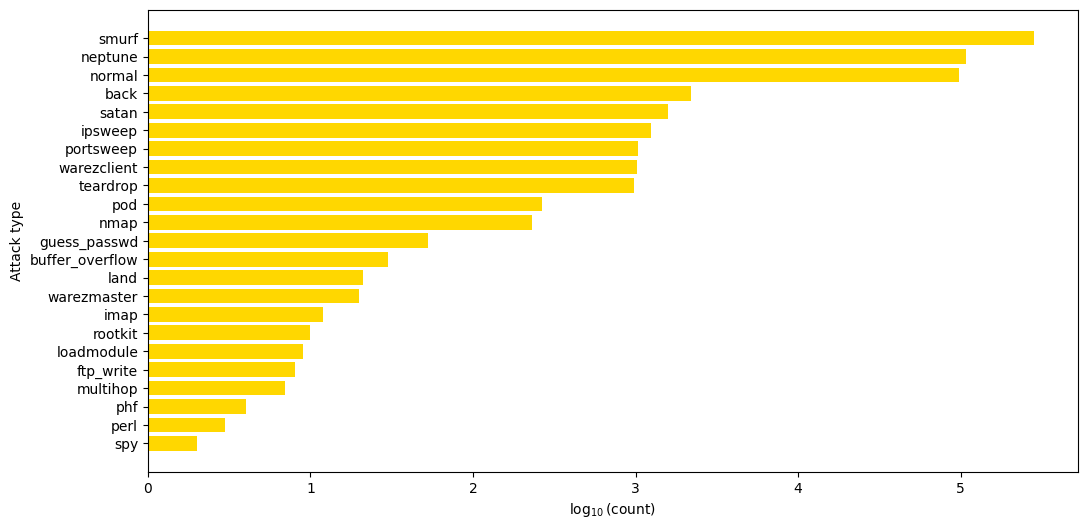

In [5]:
plt.figure(figsize=(12, 6))
plt.barh(ypos, np.log10(counts), facecolor="gold")
plt.yticks(ypos, labels=[a.decode("utf-8")[0:-1] for a in attacks])
plt.xlabel(r"$\log_{10}(\mathrm{count})$")
plt.ylabel("Attack type")
plt.show()